# Data Science 1 - Take Home Assignment

**Author: Márton Nagy**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from pathlib import Path
import pickle

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from optuna.integration import OptunaSearchCV
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping


%precision 3
pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True, precision=3)

random_state = 20250413

import warnings
warnings.filterwarnings('ignore')

# Step 1: Exploratory Data Analysis

First, I import all necessary files that were downloaded from Kaggle.

In [2]:
data_folder = 'online-news-popularity-ceu-ml-2025'
df_train_full = pd.read_csv(Path().joinpath(data_folder, 'train.csv'))
df_test = pd.read_csv(Path().joinpath(data_folder, 'test.csv'))

Luckily, there are no missing values in the dataset and the data types seem to be correct.

In [3]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

To explore relationships between the variables, let's look at a correlation heatmap first. There are a few interesting patterns we can observe:

- some features form groups, and there is large amount of correlation within these groups (e.g. keywords, or NLP features like subjectivity and polarity) - this may prompt us to do some dimensionality reductions, and I will experiment with this later;
- however, most of the variables are uncorrelated with each other;
- most importantly, there is no single feature that is highly correlated with our target variable.

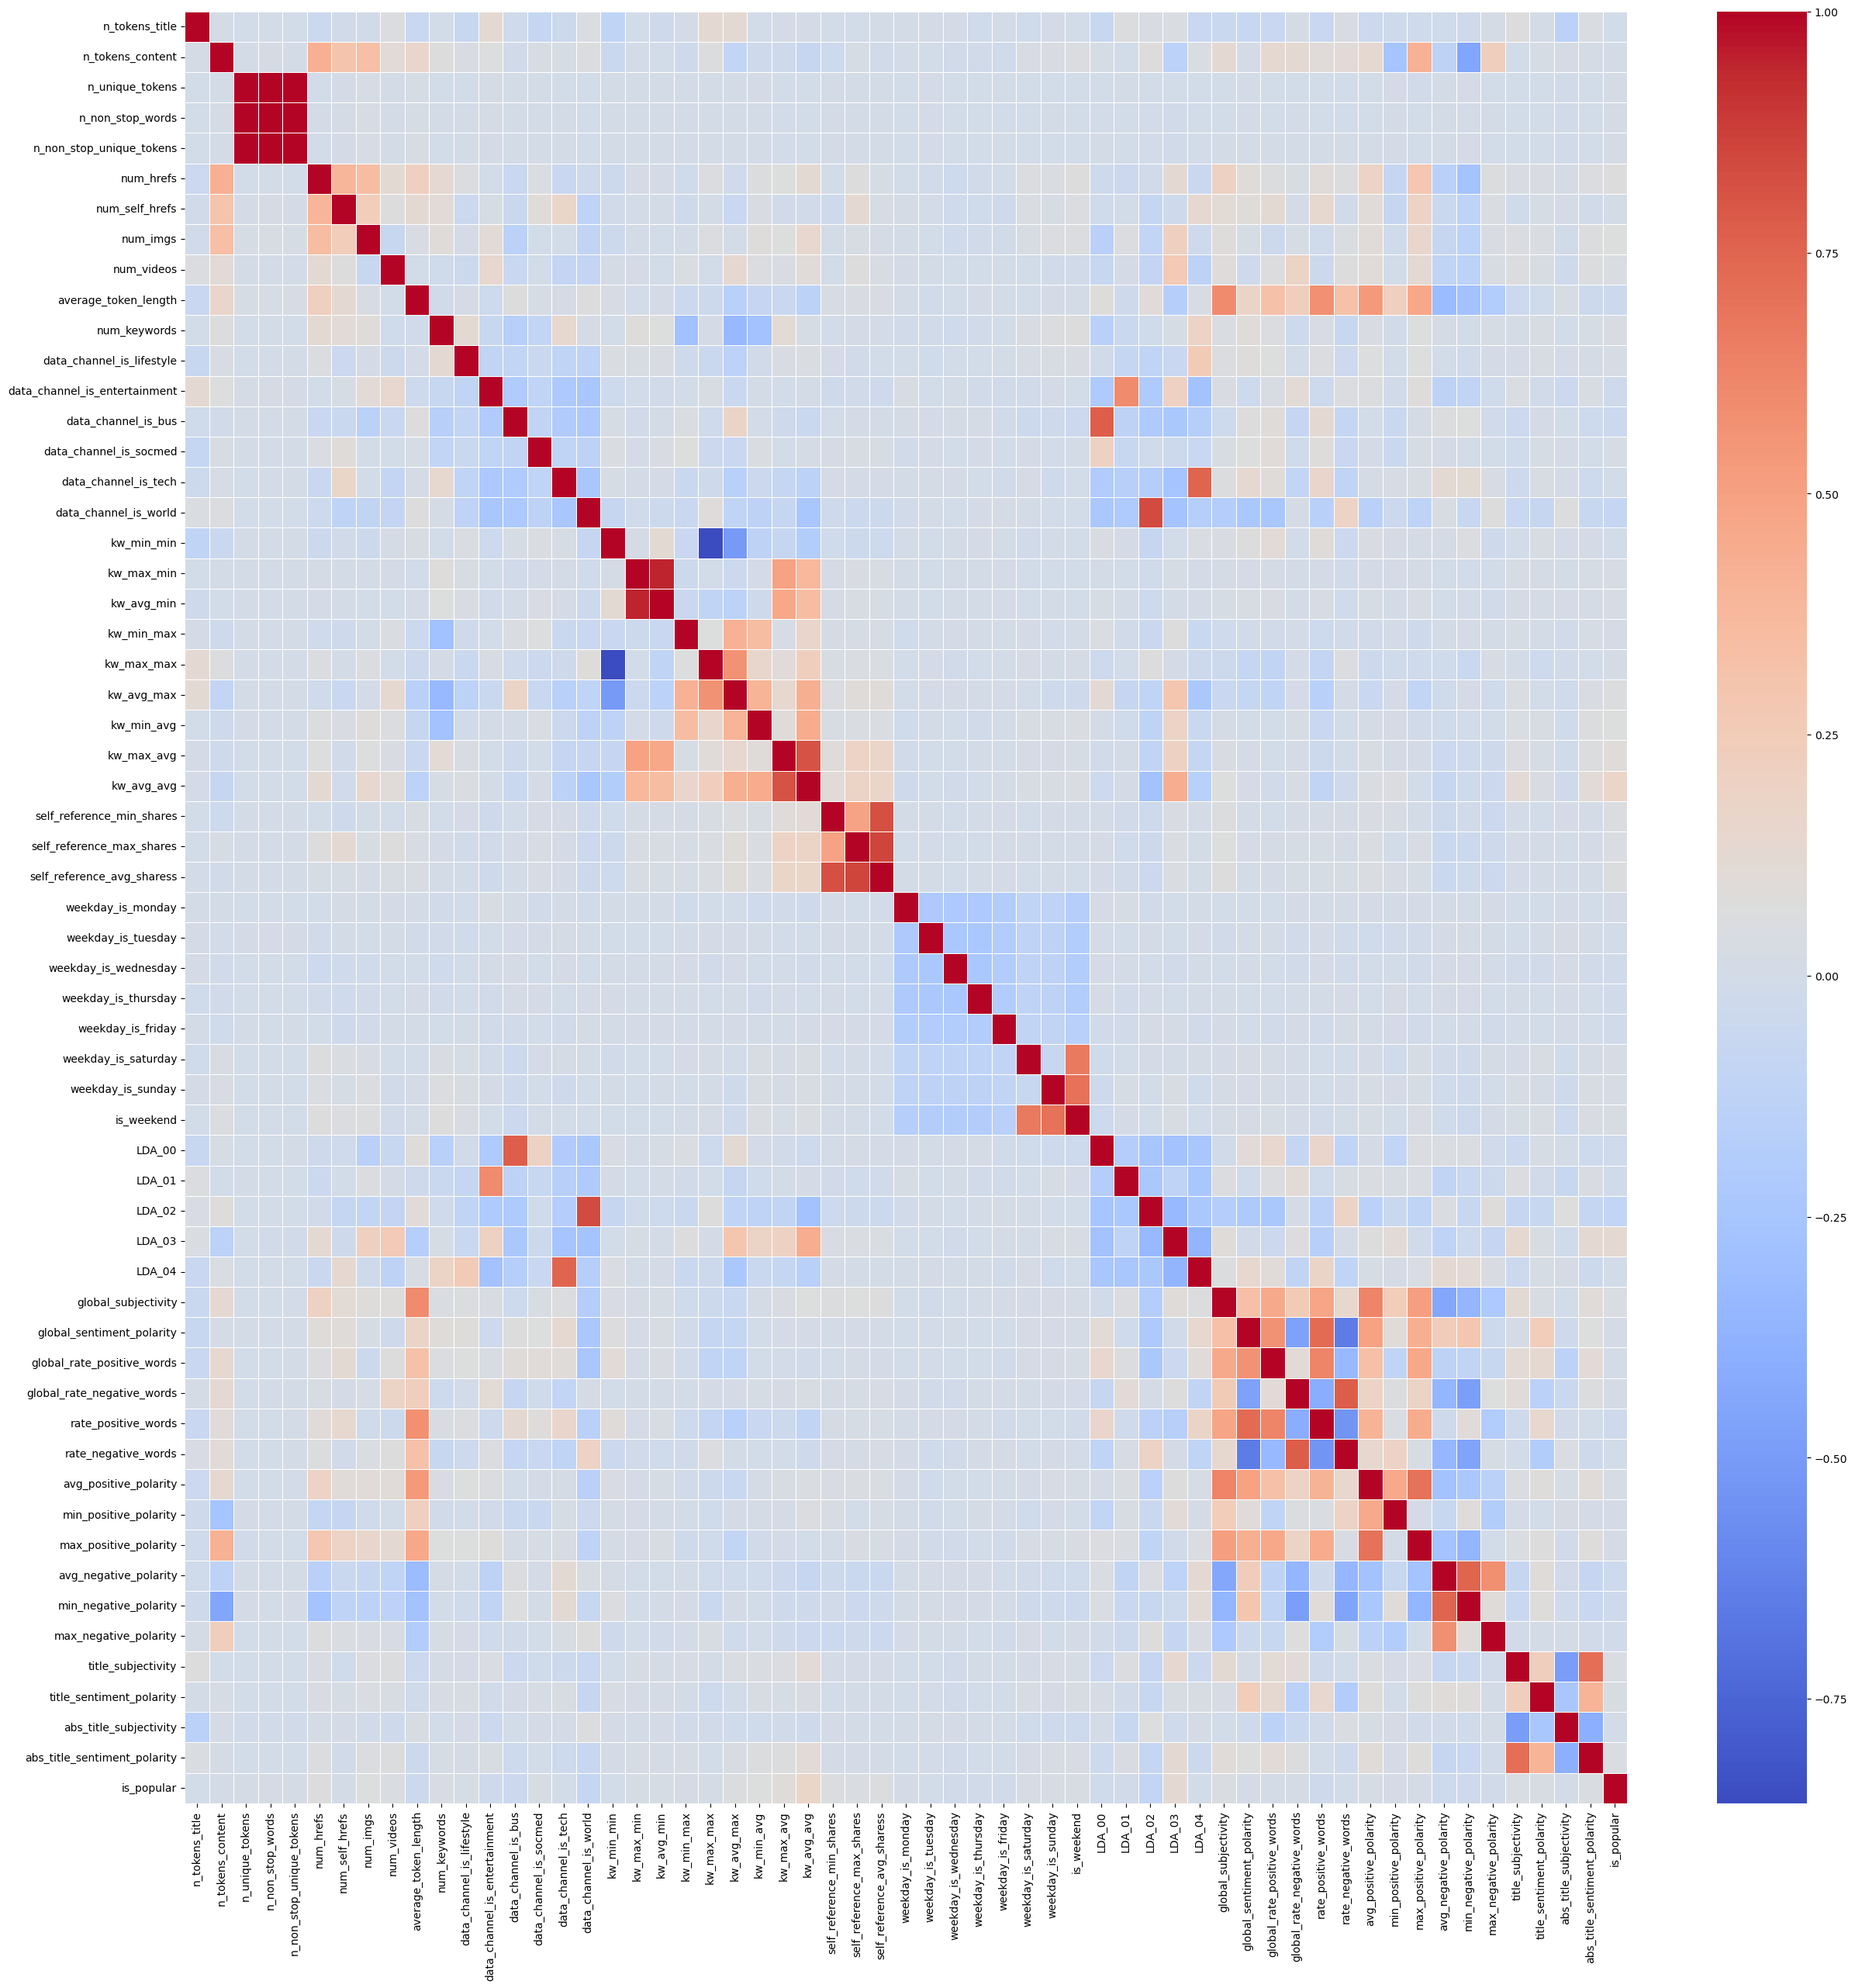

In [4]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_train_full[[c for c in df_train_full.columns if c not in ['timedelta', 'article_id']]].corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.show()

I also check the distributions of the variables. I look for skewed distributions and unusual values that may distort the results or may be indicative of data errors. As we can see, there are quite a few features with very skewed histograms. In addition, as we can see from the below summary table, some keyword columns have negative values, which is inconsistent with their definition.

Based on this, I will perform the following data preparation steps:

- I will clip the higher end of very skewed distributions (above the 99th percentiles). This way, I am able to keep all observations in the sample, but I get rid of some of the skewness.

- For the possibly erronous negative values in the keywords features, I will replace them with the sample mean, and I will also create a binary flag denoting if I have made a change.

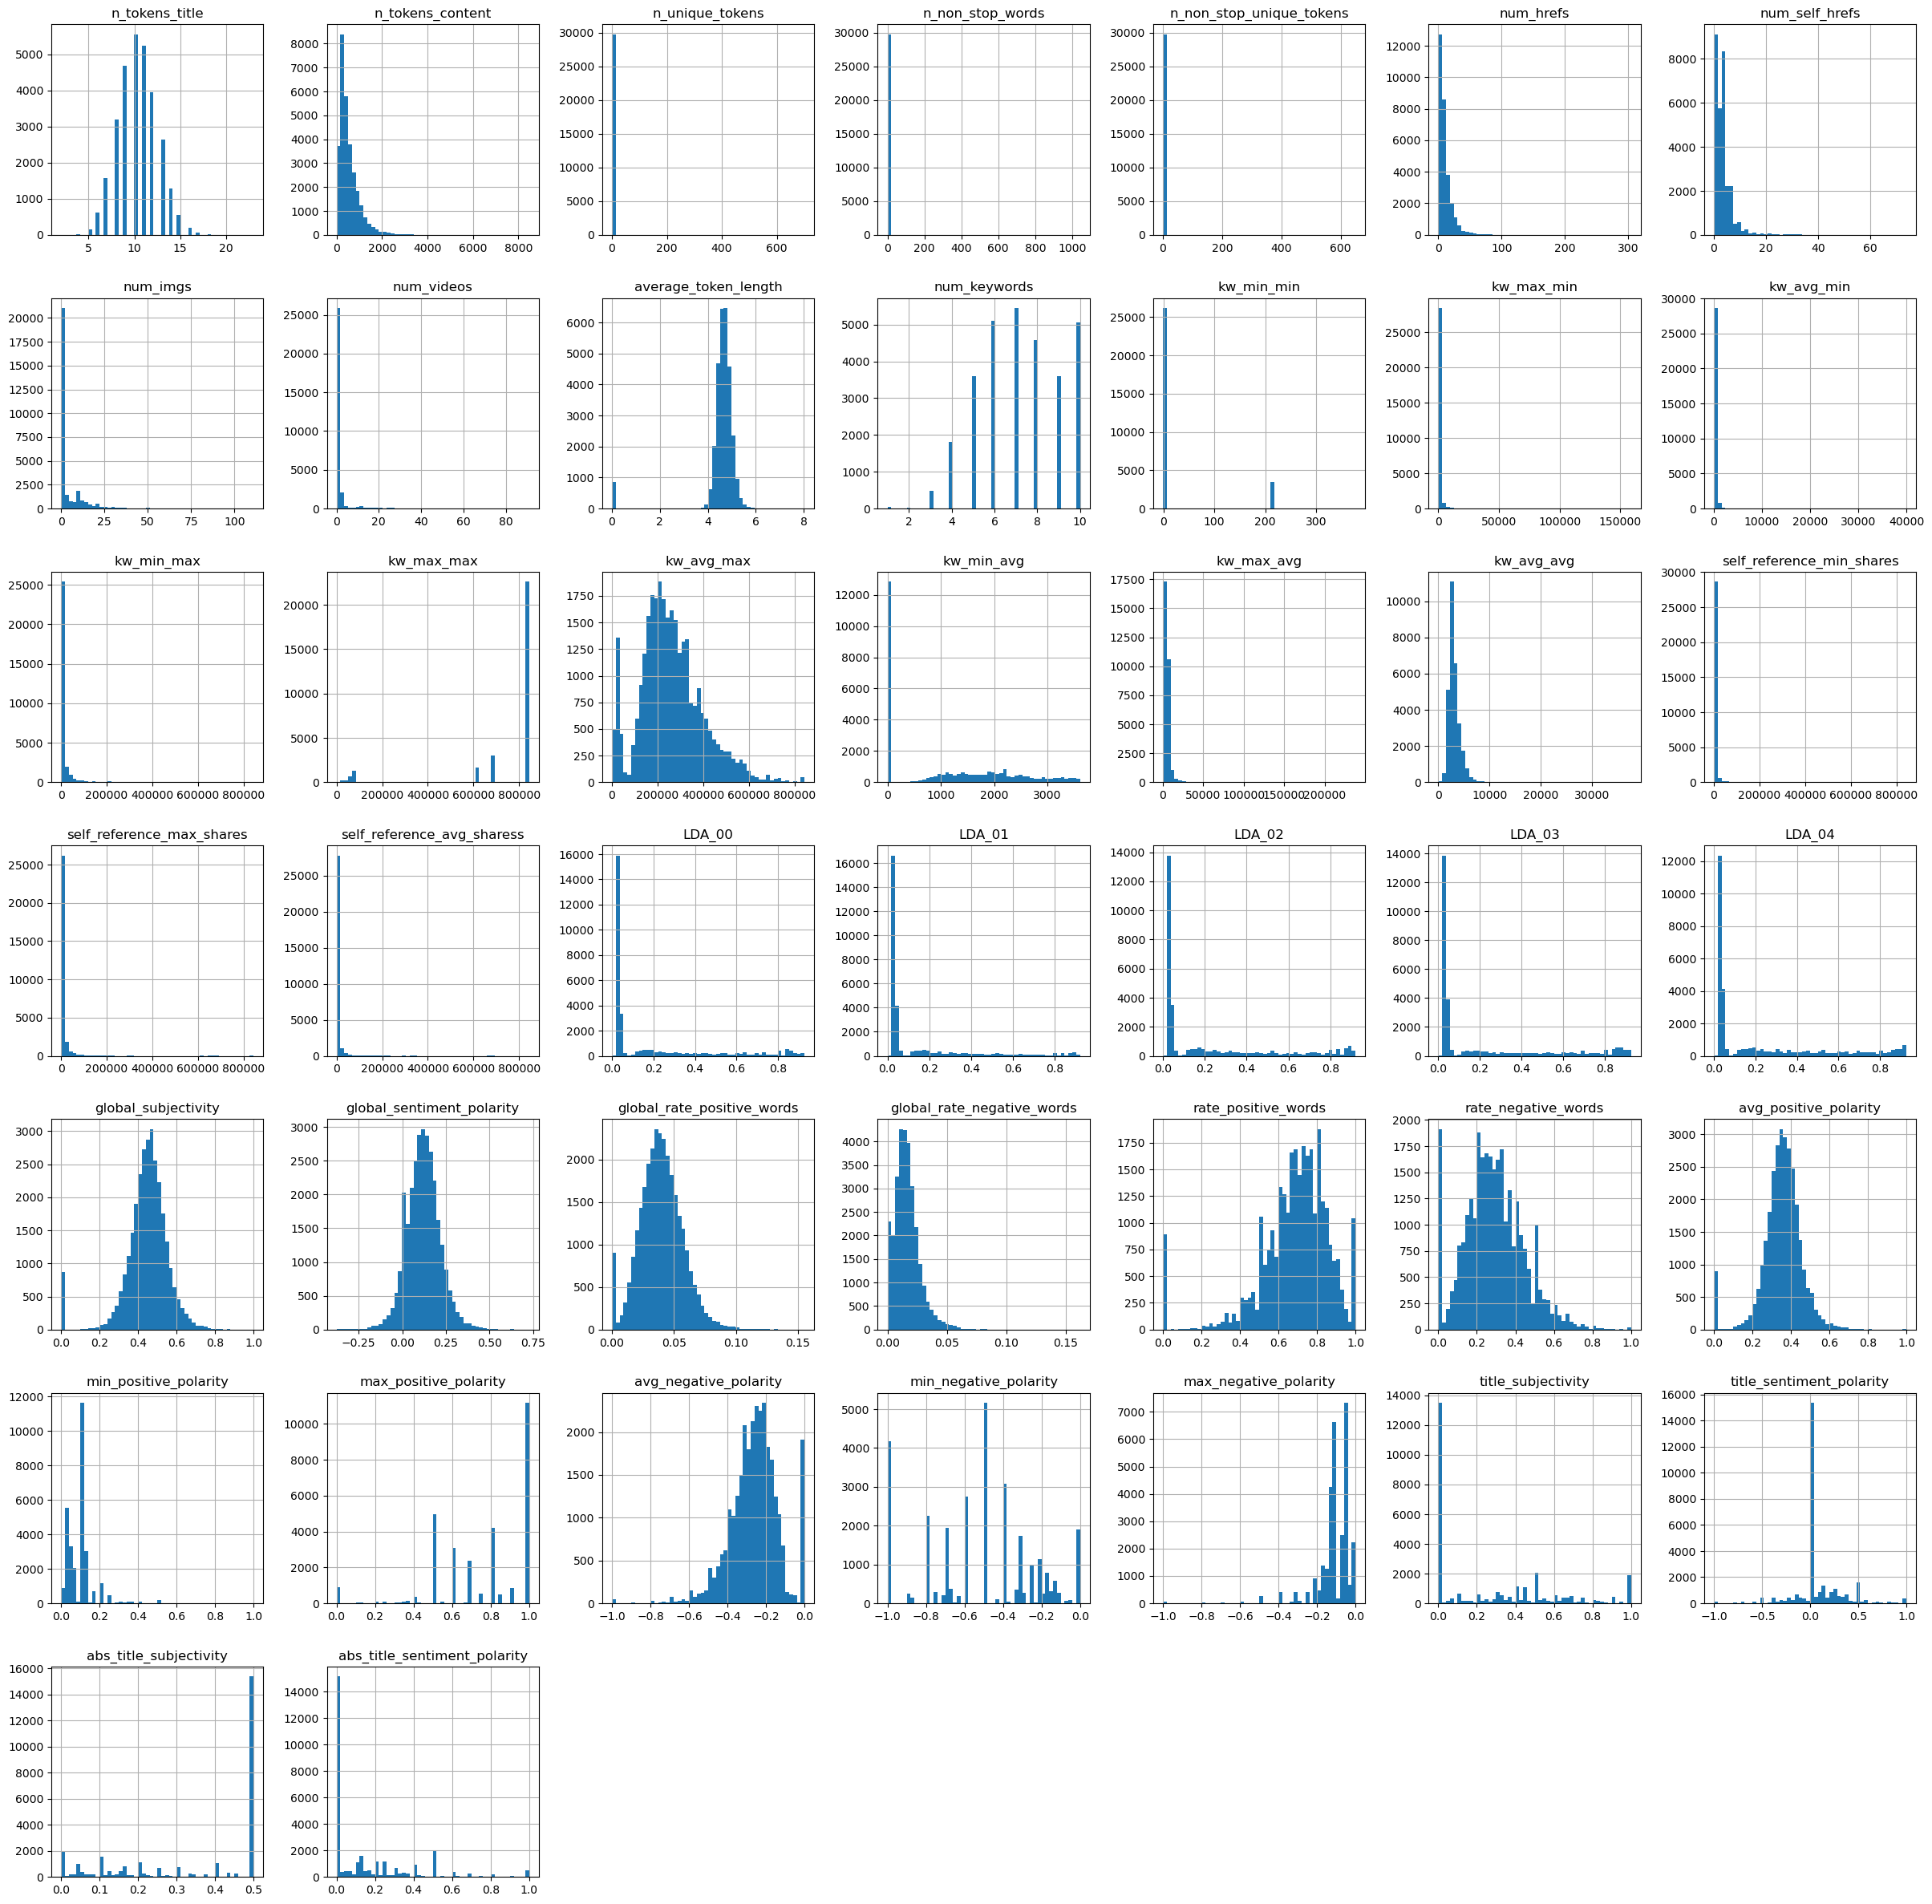

In [5]:
non_binary = [c for c in df_train_full.columns if df_train_full[c].nunique() > 2 and c not in ['timedelta', 'article_id']]
df_train_full[non_binary].hist(bins=50, figsize=(30, 30))
plt.show()

In [6]:
df_train_full[non_binary].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
n_tokens_title,29733.0,10.391,2.110,2.000,6.000,7.000,8.000,9.000,10.000,12.000,13.000,14.000,15.000,23.000
n_tokens_content,29733.0,545.008,469.358,0.000,0.000,104.000,151.000,246.000,409.000,712.000,1091.000,1396.000,2256.720,8474.000
n_unique_tokens,29733.0,0.555,4.065,0.000,0.000,0.351,0.408,0.471,0.540,0.609,0.678,0.722,0.804,701.000
n_non_stop_words,29733.0,1.006,6.040,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1042.000
n_non_stop_unique_tokens,29733.0,0.695,3.769,0.000,0.000,0.479,0.556,0.626,0.691,0.755,0.819,0.857,0.923,650.000
num_hrefs,29733.0,10.913,11.317,0.000,0.000,1.000,2.000,4.000,8.000,14.000,23.000,30.000,56.000,304.000
num_self_hrefs,29733.0,3.291,3.841,0.000,0.000,0.000,0.000,1.000,2.000,4.000,6.000,9.000,20.000,74.000
num_imgs,29733.0,4.525,8.214,0.000,0.000,0.000,0.000,1.000,1.000,4.000,14.000,20.000,36.000,111.000
num_videos,29733.0,1.264,4.189,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,6.000,21.000,91.000
average_token_length,29733.0,4.552,0.837,0.000,0.000,4.158,4.304,4.479,4.667,4.856,5.037,5.152,5.442,8.042


We can also take a look at the distributions of the binary variables. There are two things to note here:

- channels and days of week are encoded as dummy variables - this is perfectly fine for some models, but for those that can handle categorical features, I would rather have them as single categorical columns.
- the target variable seems to be rather unbalanced: only 12.2% of observations are marked as popular. We should keep this in mind, as some models (namely Random Forest and XGBoost) allow us to tune some paramaters that can account for this unbalanced nature.

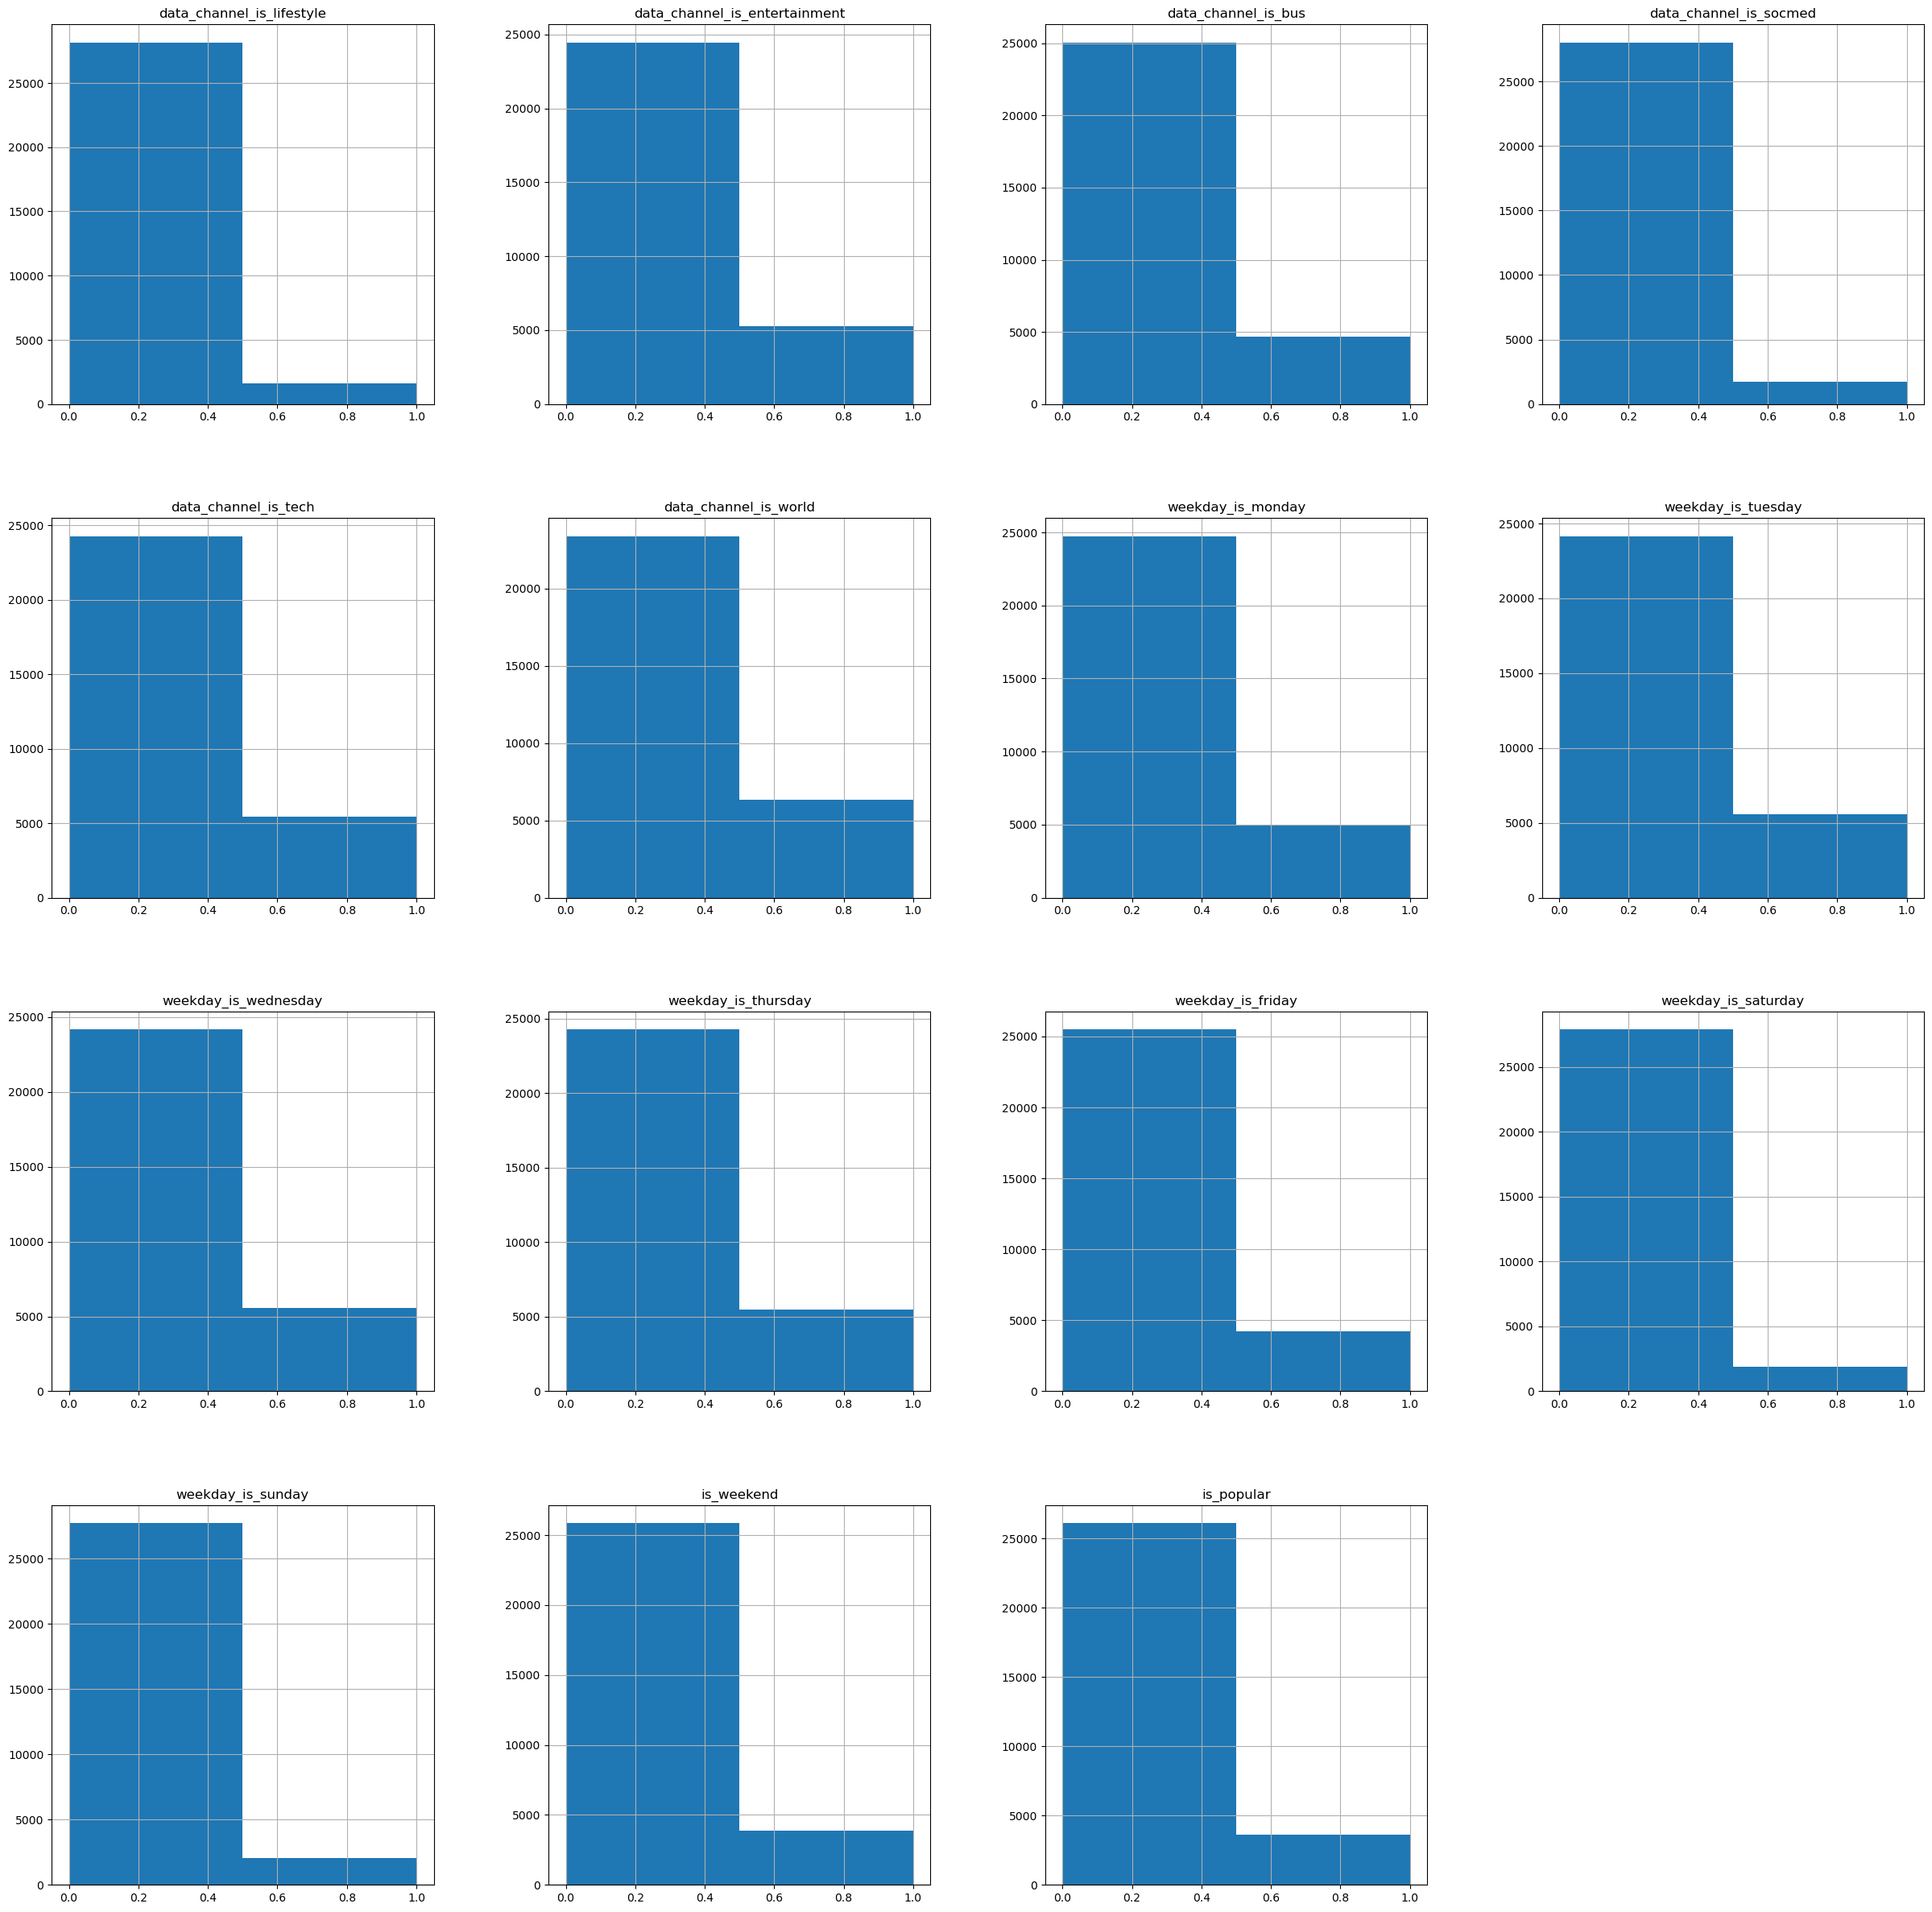

In [7]:
binary = [c for c in df_train_full.columns if df_train_full[c].nunique() <= 2 and c not in ['timedelta', 'article_id']]
df_train_full[binary].hist(bins=2, figsize=(30, 30))
plt.show()

In [8]:
df_train_full[binary].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
data_channel_is_lifestyle,29733.0,0.053,0.224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
data_channel_is_entertainment,29733.0,0.177,0.382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
data_channel_is_bus,29733.0,0.157,0.364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
data_channel_is_socmed,29733.0,0.058,0.233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
data_channel_is_tech,29733.0,0.184,0.387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
data_channel_is_world,29733.0,0.213,0.410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
weekday_is_monday,29733.0,0.168,0.373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
weekday_is_tuesday,29733.0,0.187,0.390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
weekday_is_wednesday,29733.0,0.187,0.390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
weekday_is_thursday,29733.0,0.184,0.387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


# Step 2: Data cleaning

Based on the above observations, I defined below a function to clean the data and make required transformations. As I wasn't truly precise earlier, I below outline in detail the cleaning steps I take and the rationale behind them.

**Clipping some columns above the 99th percentile**

Many columns had very skewed distributions. I account for this by assigning the value of the 99th percentile to any observations that fall above this. This does not completely eliminate the skewness, but it gets rid of extreme values at least.

**Clipping some columns at 1**

Some columns had only a handful of very large values, while the rest of the distribution fell between zero and one. Thus, for the same reason as above, I assign 1 to these extreme values.

**Handling probable errors**

Based on the provided definition, I doubt that the average token length could be zero. Thus, I flag these observations and reassign them with the median. In addition, I sense that negative or zero values in some keywords features also indicate an error. I flag these and replace them with the mean (as for some such features, the median was also negative).

**Making categorical variables**

Lastly, I create two categorical variables from day-of-week and channel dummies. I will only use these in tree-based models.

In [9]:
def clean_data(df, quantile_99, means, medians):
    df = df.copy()

    # Clip values at 99th percentile
    clip_cols = [
        'n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
        'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_avg', 'kw_avg_avg',
        'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess'
    ]
    df[clip_cols] = df[clip_cols].clip(upper=quantile_99[clip_cols], axis=1)

    # Capping values at 1
    cap_at_1_cols = ['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens']
    df[cap_at_1_cols] = df[cap_at_1_cols].clip(upper=1)

    # Handle zero values in 'average_token_length'
    df['err_average_token_length'] = (df['average_token_length'] == 0).astype(int)
    df['average_token_length'] = df['average_token_length'].replace(0, medians['average_token_length'])

    # Handle zero values in 'kw_min_min' and 'kw_avg_min'
    for col in ['kw_min_min', 'kw_avg_min', 'kw_min_avg']:
        df[f'err_{col}'] = (df[col] <= 0).astype(int)
        df[col] = df[col].mask(df[col] <= 0, means[col])

    # Compute categorical features
    df['cat_dow'] = (
        df.weekday_is_monday
        + 2 * df.weekday_is_tuesday
        + 3 * df.weekday_is_wednesday
        + 4 * df.weekday_is_thursday
        + 5 * df.weekday_is_friday
        + 6 * df.weekday_is_saturday
        + 7 * df.weekday_is_sunday
    )

    df['cat_channel'] = (
        df.data_channel_is_lifestyle
        + 2 * df.data_channel_is_entertainment
        + 3 * df.data_channel_is_bus
        + 4 * df.data_channel_is_socmed
        + 5 * df.data_channel_is_tech
        + 6 * df.data_channel_is_world
    )

    return df

I apply the defined function to both the training and the test data. As I would do in real life, I use the training set statistics for imputations in the test data set as well.

In [10]:
quantiles = df_train_full.quantile(0.99)
means = df_train_full.mean()
medians = df_train_full.median()

df_train_full = clean_data(df_train_full, quantiles, means, medians)
df_test = clean_data(df_test, quantiles, means, medians)

To save some computational power, I will build the different models only on a subsample of the full training set. Then, the best models will be refitted on the whole set.

In [11]:
df_train_sample = df_train_full.sample(frac=0.1, random_state=random_state)
train, holdout = train_test_split(df_train_sample, test_size=0.3, random_state=random_state)

I use the result collector discusses in class to store and display my results, with the addition of a CV score column.

In [12]:
class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_error, cv_error, test_error):
        """Add or update a model's results."""
        self.results[name] = {
            'Train AUC': train_error,
            'CV AUC': cv_error,
            'Hold-out AUC': test_error
        }
        return self.get_table()
    
    def get_table(self, style=True):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        if style:
            return df.style.format("{:.4f}").background_gradient(cmap='RdYlGn', axis=None)
        return df

For cross-validation, I will use the same 5-fold cross-validator for all models. This allows the CV results to be comparable.

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

I will also store and save the models.

In [14]:
models = {}

# Step 3: Model building and selection

It is important to first define a simple benchmark model, to which we can compare more complex models' results. For this, I chose a simple logistic regression without any regularization. I include all possible predictors in the model. Note that scaling before fitting the model is not necessary, but I decided to include it anyway as I found that it improved slightly the performance.

As expected, this model performs similar to the benchmark results submitted by the teacher to Kaggle. It's training AUC is already higher than the hold-out AUC, indicating that this model already captures a large portion of the patterns. All in all, we can say that if the model was given two random samples, one popular and one not popular, there is around 67-69% chance that the model will assign a higher probability of being popular to the actually popular one.

For further reference, I believe that looking at the cross-validated AUC-score is a bit more informative about model performance on unseen data, as it as an average of 5 different subsamples rather than just on unseen sample.

In [15]:
drop_cols = ['timedelta', 'article_id', 'cat_dow', 'cat_channel', 'is_popular']

In [51]:
benchmark_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=100, random_state=random_state, penalty=None, solver='saga', n_jobs=-1))
])

cv_auc = cross_val_score(benchmark_logit, train.drop(columns=drop_cols),
                         train['is_popular'], cv=kfold, scoring='roc_auc').mean()
benchmark_logit.fit(train.drop(columns=drop_cols), train['is_popular'])
train_auc = roc_auc_score(train['is_popular'],
                          benchmark_logit.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            benchmark_logit.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['Benchmark logit'] = benchmark_logit

results = ResultCollector()
results.add_model('Benchmark logit', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922


The next logical step regarding how we might improve on the benchmark is to apply some regularization to the model, meaning that we are now building a lasso-regularized logistic regression.

It is rather ambigous whether this model is an improvement compared to the benchmark: both the training and the hold-out set AUC scores have decreased, whereas the CV AUC increased a bit.

In [ ]:
lasso_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegressionCV(Cs=50, max_iter=100, random_state=random_state, scoring='roc_auc', cv=kfold,
                                   penalty='l1', refit=True, solver='saga', n_jobs=-1))
])
lasso_logit.fit(train.drop(columns=drop_cols), train['is_popular'])

cv_auc = lasso_logit.named_steps['logit'].scores_[1].mean(axis=0).max()
train_auc = roc_auc_score(train['is_popular'],
                          lasso_logit.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            lasso_logit.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['Lasso logit'] = lasso_logit

results.add_model('Lasso logit', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724


The previous models could only capture linear relationships in the data - which may or may not be the most appropriate. Thus we can also experiment with adding polynomial features and interactions. In an unregularized form, this model shows clear signs of overfitting: it performs far better on the training data then previous ones, but its performance on unseen data is dramatically lower. Therefore, we should try some regularization on this model as well.

In [ ]:
fe_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('add_poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('drop_zero_variance', VarianceThreshold()),
    ('logit', LogisticRegression(max_iter=100, random_state=random_state,
                                 penalty=None, solver='saga', n_jobs=-1))
])

cv_auc = cross_val_score(fe_logit, train.drop(columns=drop_cols),
                         train['is_popular'], cv=kfold, scoring='roc_auc').mean()

fe_logit.fit(train.drop(columns=drop_cols), train['is_popular'])
train_auc = roc_auc_score(train['is_popular'],
                          fe_logit.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            fe_logit.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['FE logit'] = fe_logit

results.add_model('FE logit', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521


The regularized model with polynomial features is presented below. We can see that we mostly got rid of the overfitting issue (lower training set performance, but higher scores on unseen data). This model, however, still cannot truly outperform the benchmark.

In [ ]:
fe_lasso_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('add_poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('drop_zero_variance', VarianceThreshold()),
    ('logit', LogisticRegressionCV(Cs=50, max_iter=100, random_state=random_state, scoring='roc_auc', cv=kfold,
                                   penalty='l1', refit=True, solver='saga', n_jobs=-1))
])

fe_lasso_logit.fit(train.drop(columns=drop_cols), train['is_popular'])
cv_auc = fe_lasso_logit.named_steps['logit'].scores_[1].mean(axis=0).max()
train_auc = roc_auc_score(train['is_popular'],
                          fe_lasso_logit.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            fe_lasso_logit.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['FE lasso logit'] = fe_lasso_logit

results.add_model('FE lasso logit', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644


I save results up to this point for further use.

In [ ]:
with open('models_cp1.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp1.pkl', 'wb') as f:
    pickle.dump(results, f)

## Checkpoint 1: Run from here for saved logit models

I load the saved models.

In [ ]:
with open('models_cp1.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp1.pkl', 'rb') as f:
    results = pickle.load(f)

Now let's turn our attention towards more complex, tree-based models. I will build Random Forest and XGBoost classifier models. First, I build a simple Random Forest with the default settings, mainly to serve as a benchmark for tree-based models.

As we can see, it's CV AUC score (what I care about more) is significantly higher than that of the benchmark logit model (although the hold-out set performance is slightly lower). Thus, we have found the first model that could outperform the benchmark. Also, note that this model learned the training data perfectly, so it is very much overfitted (though in the end, what matters more, is its performance on unseen data).

In [ ]:
rf_simple = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('rf', RandomForestClassifier(criterion ='gini', random_state=random_state, n_jobs=-1))
])

cv_auc = cross_val_score(rf_simple, train, train['is_popular'], cv=kfold, scoring='roc_auc').mean()
rf_simple.fit(train, train['is_popular'])
train_auc = roc_auc_score(train['is_popular'], rf_simple.predict_proba(train)[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'], rf_simple.predict_proba(holdout)[:, 1])

models['Default RF'] = rf_simple

results.add_model('Default RF', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815


Now let's build a more adequate, tuned Random Forest model. As I want to search over a relatively large parameter grid with relatively little computational resources, I utilize a *halving grid search*, which starts evaluating parameter sets on very small samples, and gradually increases the sample size for parameters that are more and more promising.

Tuning the Random Forest was a good idea, as the results could be further improved, and now both the CV and the hold-out set AUC stands above 0.7.

In [ ]:
rf_tuned = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('rf', RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=-1))
])

param_grid = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [20, 30, 40],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__class_weight': ['balanced', 'balanced_subsample', None]
}

rf_tuned_cv = HalvingGridSearchCV(rf_tuned, param_grid, cv=kfold, scoring='roc_auc', n_jobs=-1, refit=True)

rf_tuned_cv.fit(train, train['is_popular'])

cv_auc = cross_val_score(rf_tuned_cv.best_estimator_, train, train['is_popular'],
                         cv=kfold, scoring='roc_auc').mean()
train_auc = roc_auc_score(train['is_popular'],
                          rf_tuned_cv.predict_proba(train)[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            rf_tuned_cv.predict_proba(holdout)[:, 1])

models['Tuned RF'] = rf_tuned_cv

results.add_model('Tuned RF', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221


I save my interim results again, as tuning the RF takes a considerable amount of time.

In [ ]:
with open('models_cp2.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp2.pkl', 'wb') as f:
    pickle.dump(results, f)

## Checkpoint 2: Run from here for saved RF models

I load the saved models.

In [ ]:
with open('models_cp2.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp2.pkl', 'rb') as f:
    results = pickle.load(f)

I will now build some XGBoost classifiers. As these can handle categorical features, I will convert the day of week and channel features to categorical variables (these were included as integers in the Random Forests).

In [16]:
def convert_to_categorical(df):
    df = df.copy()
    df['cat_dow'] = df['cat_dow'].astype('category')
    df['cat_channel'] = df['cat_channel'].astype('category')
    return df

Just like before, I start with a simple model with the default settings. From the results it seems that this model is not quite good: it performs around the same level as the benchmark logit did. But this may just be an issue with tuning, as the default settings might not be appropriate for this problem.

In [ ]:
xgb_basic = Pipeline([
    ('category', FunctionTransformer(convert_to_categorical)),
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('xgb', XGBClassifier(objective='binary:logistic',
                          eval_metric='auc', random_state=random_state,
                          n_jobs=-1, enable_categorical=True))
])

cv_auc = cross_val_score(xgb_basic, train, train['is_popular'], cv=kfold, scoring='roc_auc').mean()
xgb_basic.fit(train, train['is_popular'])
train_auc = roc_auc_score(train['is_popular'],
                          xgb_basic.predict_proba(train)[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            xgb_basic.predict_proba(holdout)[:, 1])

models['Default XGB'] = xgb_basic

results.add_model('Default XGB', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920


For tuning the model, I take the same approach as before, using the *halving grid search*. The results suggest a clear improvement compared to the default model, making XGBoost perform above 0.7 AUC as well. Note, however, that the tuned Random Forest still clearly outperforms the tuned XGBoost.

In [ ]:
tuned_xgb = Pipeline([
    ('category', FunctionTransformer(convert_to_categorical)),
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='auc',
                          random_state=random_state, n_jobs=-1, enable_categorical=True))
])

param_grid = {
    'xgb__n_estimators': [100, 200, 300, 400],
    'xgb__max_depth': [5, 7, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.5, 1],
    'xgb__reg_lambda': [0, 0.1, 0.5, 1],
    'xgb__scale_pos_weight': [1, 3, np.sum(train['is_popular'] == 0) / np.sum(train['is_popular'] == 1), 10]
}

tuned_xgb_cv = HalvingGridSearchCV(tuned_xgb, param_grid, cv=kfold, scoring='roc_auc', n_jobs=-1, refit=True)
tuned_xgb_cv.fit(train, train['is_popular'])


cv_auc = cross_val_score(tuned_xgb_cv.best_estimator_, train, train['is_popular'],
                         cv=kfold, scoring='roc_auc', n_jobs=-1).mean()
train_auc = roc_auc_score(train['is_popular'],
                          tuned_xgb_cv.predict_proba(train)[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            tuned_xgb_cv.predict_proba(holdout)[:, 1])

models['Tuned XGB'] = tuned_xgb_cv

results.add_model('Tuned XGB', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090


Saving the results again.

In [ ]:
with open('models_cp3.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp3.pkl', 'wb') as f:
    pickle.dump(results, f)

## Checkpoint 3: Run from here for saved XGB models

Loading the saved models.

In [ ]:
with open('models_cp3.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp3.pkl', 'rb') as f:
    results = pickle.load(f)

The next model I want to experiment with is an MLP, using Keras. Even though I have heard that neural networks usually underperform tree-based approaches on tabular data, I wanted to see whether this was truly the case.

The results suggest that indeed, the MLP architecture fails to adequately capture relevant patterns in the data, making it even worse than the benchmark logit.

In [ ]:
set_random_seed(random_state)
dropout_rate = 0.35

X_train = train.drop(columns=drop_cols)
y_train = train['is_popular']
X_holdout = holdout.drop(columns=drop_cols)
y_holdout = holdout['is_popular']

fold_aucs = []
for train_idx, val_idx in kfold.split(X_train, y_train):
    mlp = Sequential([
        Input(shape=(train.drop(columns=drop_cols).shape[1],)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    mlp.fit(X_train.iloc[train_idx], y_train.iloc[train_idx],
            validation_data=(X_train.iloc[val_idx], y_train.iloc[val_idx]),
            epochs=100, batch_size=128, callbacks=[early_stopping], verbose=0)
    fold_aucs.append(roc_auc_score(y_train.iloc[val_idx],
                                   mlp.predict(X_train.iloc[val_idx], verbose=0)))
    
cv_auc = np.mean(fold_aucs)

mlp = Sequential([
    Input(shape=(train.drop(columns=drop_cols).shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

mlp.fit(train.drop(columns=drop_cols), train['is_popular'],
        validation_data=(holdout.drop(columns=drop_cols), holdout['is_popular']),
        epochs=100, batch_size=128, callbacks=[early_stopping], verbose=0)

train_auc = roc_auc_score(y_train, mlp.predict(X_train, verbose=0))
holdout_auc = roc_auc_score(y_holdout, mlp.predict(X_holdout, verbose=0))
results.add_model('Keras MLP', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678


There is one more thing to experiment with: applying some dimensionality reduction before fitting the models. This may be a sensible idea given that some of the features were highly correlated, though in principle, this should not improve predictive performance. For simplicity, I only experiment with models having a PCA step in the pipeline for (lasso) logit models. As we can see below, the AUC scores could not be improved by having the PCA in the model. What we have gained though is significantly lower training times. This is a good advantage to have in certain cases, but for this exercise, it does not really matter.

In [ ]:
benchmark_logit_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=random_state)),
    ('logit', LogisticRegression(max_iter=100, random_state=random_state, penalty=None, solver='saga', n_jobs=-1))
])

cv_auc = cross_val_score(benchmark_logit_pca, train.drop(columns=drop_cols),
                         train['is_popular'], cv=kfold, scoring='roc_auc').mean()
benchmark_logit_pca.fit(train.drop(columns=drop_cols), train['is_popular'])
train_auc = roc_auc_score(train['is_popular'],
                          benchmark_logit_pca.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            benchmark_logit_pca.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['Benchmark logit with PCA'] = benchmark_logit_pca

results.add_model('Benchmark logit with PCA', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


In [ ]:
lasso_logit_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=random_state)),
    ('logit', LogisticRegressionCV(Cs=50, max_iter=100, random_state=random_state, scoring='roc_auc', cv=kfold,
                                   penalty='l1', refit=True, solver='saga', n_jobs=-1))
])
lasso_logit_pca.fit(train.drop(columns=drop_cols), train['is_popular'])

cv_auc = lasso_logit_pca.named_steps['logit'].scores_[1].mean(axis=0).max()
train_auc = roc_auc_score(train['is_popular'],
                          lasso_logit_pca.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            lasso_logit_pca.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['Lasso logit with PCA'] = lasso_logit_pca

results.add_model('Lasso logit with PCA', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


In [ ]:
fe_lasso_logit_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('add_poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('drop_zero_variance', VarianceThreshold()),
    ('pca', PCA(n_components=0.95, random_state=random_state)),
    ('logit', LogisticRegressionCV(Cs=50, max_iter=100, random_state=random_state, scoring='roc_auc', cv=kfold,
                                   penalty='l1', refit=True, solver='saga', n_jobs=-1))
])

fe_lasso_logit_pca.fit(train.drop(columns=drop_cols), train['is_popular'])
cv_auc = fe_lasso_logit_pca.named_steps['logit'].scores_[1].mean(axis=0).max()
train_auc = roc_auc_score(train['is_popular'],
                          fe_lasso_logit_pca.predict_proba(train.drop(columns=drop_cols))[:, 1])
holdout_auc = roc_auc_score(holdout['is_popular'],
                            fe_lasso_logit_pca.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['FE lasso logit with PCA'] = fe_lasso_logit_pca

results.add_model('FE lasso logit with PCA', train_auc, cv_auc, holdout_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


Saving all results.

In [ ]:
with open('models_cp4.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp4.pkl', 'wb') as f:
    pickle.dump(results, f)

# Step 4: Model evaluation using the full sample

As mentioned before, the models were built using only 10 percent of the available training data. However, adding more training data to the best models may result in increased performance as the models may learn more nuanced patterns.

As my best models were the tuned Random Forest and the tuned XGB classifiers, I will retrain these (with the previously found hyperparameters), together whith the benchmark logit model (partly because it is not that behind the best models, and partly becuase I want to have a full-sample benchmark as well).

Note that I will use the same holdout set as before so that the results remain comparable.

## Checkpoint 4: Run from here for saved models on sampled data

In [31]:
with open('models_cp4.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp4.pkl', 'rb') as f:
    results = pickle.load(f)

In [32]:
full_train = df_train_full[~df_train_full.index.isin(holdout.index)]

For the benchmark model, the addition of extra data clearly helped improve the results, as both the cross-validated and the hold-out set AUC scores improved.

In [33]:
benchmark_logit_full = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000, random_state=random_state, penalty=None, solver='saga', n_jobs=-1))
])

cv_auc = cross_val_score(benchmark_logit_full, full_train.drop(columns=drop_cols),
                         full_train['is_popular'], cv=kfold, scoring='roc_auc', n_jobs=-1).mean()
benchmark_logit_full.fit(full_train.drop(columns=drop_cols), full_train['is_popular'])
train_auc = roc_auc_score(full_train['is_popular'],
                          benchmark_logit_full.predict_proba(full_train.drop(columns=drop_cols))[:, 1])
test_auc = roc_auc_score(holdout['is_popular'],
                         benchmark_logit_full.predict_proba(holdout.drop(columns=drop_cols))[:, 1])

models['Benchmark logit (full sample)'] = benchmark_logit_full
results.add_model('Benchmark logit (full sample)', train_auc, cv_auc, test_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


On the contrary, using the full sample to train the model could not improve the Random Forest results. In fact, the hold-out set AUC is actually somewhat lower than previously. Nonetheless, this model still seems to outperform the benchmark, even on the full sample.

In [34]:
rf_tuned_full = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('rf', RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=-1,
                                  n_estimators=models['Tuned RF'].best_params_['rf__n_estimators'],
                                  max_depth=models['Tuned RF'].best_params_['rf__max_depth'],
                                  min_samples_split=models['Tuned RF'].best_params_['rf__min_samples_split'],
                                  min_samples_leaf=models['Tuned RF'].best_params_['rf__min_samples_leaf'],
                                  max_features=models['Tuned RF'].best_params_['rf__max_features'],
                                  class_weight=models['Tuned RF'].best_params_['rf__class_weight']))
])

cv_auc = cross_val_score(rf_tuned_full, full_train, full_train['is_popular'],
                         cv=kfold, scoring='roc_auc', n_jobs=-1).mean()
rf_tuned_full.fit(full_train, full_train['is_popular'])
train_auc = roc_auc_score(full_train['is_popular'],
                          rf_tuned_full.predict_proba(full_train)[:, 1])
test_auc = roc_auc_score(holdout['is_popular'],
                         rf_tuned_full.predict_proba(holdout)[:, 1])

models['Tuned RF (full sample)'] = rf_tuned_full
results.add_model('Tuned RF (full sample)', train_auc, cv_auc, test_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


We can observe the same tendencies regarding the XGB model. The addition of extra data could not improve the results, but its CV AUC is still better than that of the benchmark.

In [35]:
xgb_tuned_full = Pipeline([
    ('category', FunctionTransformer(convert_to_categorical)),
    ('column_transformer', ColumnTransformer([
        ('select_cols',
         'passthrough',
         [c for c in train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c])])),
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=random_state, n_jobs=-1, enable_categorical=True,
                          n_estimators=models['Tuned XGB'].best_params_['xgb__n_estimators'],
                          max_depth=models['Tuned XGB'].best_params_['xgb__max_depth'],
                          learning_rate=models['Tuned XGB'].best_params_['xgb__learning_rate'],
                          subsample=models['Tuned XGB'].best_params_['xgb__subsample'],
                          colsample_bytree=models['Tuned XGB'].best_params_['xgb__colsample_bytree'],
                          reg_alpha=models['Tuned XGB'].best_params_['xgb__reg_alpha'],
                          reg_lambda=models['Tuned XGB'].best_params_['xgb__reg_lambda'],
                          scale_pos_weight=models['Tuned XGB'].best_params_['xgb__scale_pos_weight']))
])

cv_auc = cross_val_score(xgb_tuned_full, full_train, full_train['is_popular'],
                         cv=kfold, scoring='roc_auc', n_jobs=-1).mean()
xgb_tuned_full.fit(full_train, full_train['is_popular'])
train_auc = roc_auc_score(full_train['is_popular'],
                          xgb_tuned_full.predict_proba(full_train)[:, 1])
test_auc = roc_auc_score(holdout['is_popular'],
                         xgb_tuned_full.predict_proba(holdout)[:, 1])

models['Tuned XGB (full sample)'] = xgb_tuned_full
results.add_model('Tuned XGB (full sample)', train_auc, cv_auc, test_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


In [36]:
with open('models_cp5.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp5.pkl', 'wb') as f:
    pickle.dump(results, f)

## Checkpoint 5: Run from here for saved retrained models on full sample

In [85]:
with open('models_cp5.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp5.pkl', 'rb') as f:
    results = pickle.load(f)

As noted before, the RF and XGB models' performance could not be improved by simply adding more data to the equation. This may be because of two things:

- The models either learned all the patterns already, and there really is nothing more to add;
- Or the best hyperparameters that were found on the sampled data are not quite appropriate for the full dataset.

To address the possibility of this second issue, I will re-tune the RF and XGB models on the full training set. This time, I will use `Optuna` to do the search over the hyperparameter space, as I have found that it provides more promising results in the same amount of time than halving grid search (and as I also wanted to showcase another hyperparameter optimization approach). However, for reproducibility, I cannot parallelize the trials, as they build on each other (thus parallelization and the undeterministic nature of which job finishes when would lead to different results at every run).

In [87]:
feature_cols = [c for c in full_train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c]

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'random_state': random_state,
        'n_jobs': -1,
    }

    pipeline = Pipeline([
        ('column_transformer', ColumnTransformer([
            ('select_cols', 'passthrough', feature_cols)
        ])),
        ('rf', RandomForestClassifier(**params))
    ])

    cv_auc = cross_val_score(pipeline, full_train, full_train['is_popular'],
                             cv=kfold, scoring='roc_auc', n_jobs=-1)
    return cv_auc.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=100, n_jobs=1)

best_params = study.best_trial.params
best_params['random_state'] = random_state
best_params['n_jobs'] = -1

rf_retuned_full = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('select_cols', 'passthrough', feature_cols)
    ])),
    ('rf', RandomForestClassifier(**best_params))
])

cv_auc = study.best_value

In [91]:
rf_retuned_full.fit(full_train, full_train['is_popular'])

train_auc = roc_auc_score(full_train['is_popular'], rf_retuned_full.predict_proba(full_train)[:, 1])
test_auc = roc_auc_score(holdout['is_popular'], rf_retuned_full.predict_proba(holdout)[:, 1])

models['Re-tuned RF (full sample)'] = rf_retuned_full
results.add_model('Re-tuned RF (full sample)', train_auc, cv_auc, test_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


Retuning on the full sample only marginally improved the CV performance of our Random Forest model - though this still may be an important improvement in the competition.

Now let's retune the XGBoost model on the full sample as well.

In [ ]:
feature_cols = [c for c in full_train.columns if c not in ['timedelta', 'article_id', 'is_popular'] and '_is_' not in c]

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': random_state,
        'n_jobs': -1,
        'objective' : 'binary:logistic',
        'eval_metric': 'auc',
        'enable_categorical': True
    }

    pipeline = Pipeline([
    ('category', FunctionTransformer(convert_to_categorical)),
    ('column_transformer', ColumnTransformer([
        ('select_cols', 'passthrough', feature_cols)])),
    ('xgb', XGBClassifier(**params))
    ])

    cv_auc = cross_val_score(pipeline, full_train, full_train['is_popular'],
                             cv=kfold, scoring='roc_auc', n_jobs=-1)
    
    return cv_auc.mean()

xgb_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
xgb_study.optimize(objective, n_trials=100, n_jobs=1)

best_params = xgb_study.best_trial.params
best_params['random_state'] = random_state
best_params['n_jobs'] = -1
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['enable_categorical'] = True

xgb_retuned_full = Pipeline([
    ('category', FunctionTransformer(convert_to_categorical)),
    ('column_transformer', ColumnTransformer([
        ('select_cols', 'passthrough', feature_cols)
    ])),
    ('xgb', XGBClassifier(**best_params))
])

cv_auc = xgb_study.best_value

In [ ]:
xgb_retuned_full.fit(full_train, full_train['is_popular'])

train_auc = roc_auc_score(full_train['is_popular'], xgb_retuned_full.predict_proba(full_train)[:, 1])
test_auc = roc_auc_score(holdout['is_popular'], xgb_retuned_full.predict_proba(holdout)[:, 1])

models['Re-tuned XGB (full sample)'] = xgb_retuned_full
results.add_model('Re-tuned XGB (full sample)', train_auc, cv_auc, test_auc)

,Train AUC,CV AUC,Hold-out AUC
Benchmark logit,0.7522,0.6697,0.6922
Lasso logit,0.6952,0.6879,0.6724
FE logit,0.9511,0.5905,0.6521
FE lasso logit,0.7069,0.6787,0.6644
Default RF,1.0000,0.7008,0.6815
Tuned RF,1.0000,0.7151,0.7221
Default XGB,1.0000,0.6658,0.6920
Tuned XGB,0.9299,0.7021,0.7090
Keras MLP,0.7068,0.6300,0.6678
Benchmark logit with PCA,0.7245,0.6560,0.6893


Interestingly, re-tuning XGB on the full sample seem to have helped a bit more, though its CV score is still lower than that of the re-tuned Random Forest.

As neither of the models is too bad (and as I am allowed to submit multiple predictions), I will retrain

- the benchmark logit,
- the tuned RF,
- the tuned XGB,
- the full-sample re-tuned RF,
- and the full-sample re-tuned XGB as well

using all available training data (thus the hold-out set as well).

I expect the following order of results on Kaggle based on CV results:

1. Re-tuned RF (full sample)
2. Re-tuned XGB (full sample)
3. Tuned RF (full sample)
4. Tuned XGB (full sample)
5. Benchmark logit (full sample)

After submission, the following public AUC scores were achieved, mostly in line with my expectations (except for the first place):

1. Re-tuned XGB (full sample): 0.7316
2. Re-tuned RF (full sample): 0.7213
3. Tuned RF (full sample): 0.7212
4. Tuned XGB (full sample): 0.7175
5. Benchmark logit (full sample): 0.7121

In [96]:
with open('models_cp6.pkl', 'wb') as f:
    pickle.dump(models, f)
with open('results_cp6.pkl', 'wb') as f:
    pickle.dump(results, f)

## Checkpoint 6: Run from here for all saved models

In [97]:
with open('models_cp6.pkl', 'rb') as f:
    models = pickle.load(f)
with open('results_cp6.pkl', 'rb') as f:
    results = pickle.load(f)

I load the best models.

In [98]:
benchmark_logit_full = models['Benchmark logit (full sample)']
rf_tuned_full = models['Tuned RF (full sample)']
xgb_tuned_full = models['Tuned XGB (full sample)']
rf_retuned_full = models['Re-tuned RF (full sample)']
xgb_retuned_full = models['Re-tuned XGB (full sample)']

I retrain all mentioned models on all available data and make the predictions on the test set.

In [100]:
benchmark_logit_full.fit(df_train_full.drop(columns=drop_cols), df_train_full['is_popular'])
rf_tuned_full.fit(df_train_full, df_train_full['is_popular'])
xgb_tuned_full.fit(df_train_full, df_train_full['is_popular'])
rf_retuned_full.fit(df_train_full, df_train_full['is_popular'])
xgb_retuned_full.fit(df_train_full, df_train_full['is_popular'])
df_test['logit_pred'] = benchmark_logit_full.predict_proba(df_test.drop(columns=drop_cols[:-1]))[:, 1]
df_test['rf_pred'] = rf_tuned_full.predict_proba(df_test)[:, 1]
df_test['xgb_pred'] = xgb_tuned_full.predict_proba(df_test)[:, 1]
df_test['rf_retuned_pred'] = rf_retuned_full.predict_proba(df_test)[:, 1]
df_test['xgb_retuned_pred'] = xgb_retuned_full.predict_proba(df_test)[:, 1]

Defining a function to export predictions in the right format.

In [101]:
def export_predictions_to_csv(df, filename, pred_col):
    df = df.copy()
    df.rename(columns={pred_col: 'score'}, inplace=True)
    df[['article_id', 'score']].to_csv(filename, index=False)

And actually exporting them.

In [102]:
for col in ['logit_pred', 'rf_pred', 'xgb_pred', 'rf_retuned_pred', 'xgb_retuned_pred']:
    export_predictions_to_csv(df_test, f'predictions_{col}.csv', col)

# Step 5: Conclusion and evaluation of results

To sum up, my best model could achieve an AUC score around 0.73 on Kaggle, meaning that if given two randomly chosen observations, one popular and one not popular, the model will assign a larger probability of being popular to the actually popular one with a probability of 73%. As I have looked through the reference paper where this dataset was introduced, I believe this is a rather good result. In that paper, the best model could achieve an AUC around 0.73, thus my model is as good as the model introduced in that paper.

There are a few interesting observations I made during the exercise, which I will summarize here:

- outperforming the simple logistic regression was much harder than I first thought - even those models that could outperform it were only marginally better;
- tree-based algorithms seem to be more suited to tabular, probability prediction tasks than neural networks
- adding more data and re-tuning the best models on the full sample could improve results a bit, though the models could perform already quite well with the parameters found on the sampled data
- comparing the submission results with my CV and hold-out AUC estimates, we can see that cross-validation and having a holdout-set could help us a lot in determining which model would be better on unseen data - though the actual CV and holdout AUC scores are somewhat different from the Kaggle public results achieved.